In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score, confusion_matrix
import scipy
import itertools
%matplotlib inline

## Data Cleaning

In [2]:
cols = 'age workclass fnlwgt education education-num marital-status occupation relationship race sex ' \
       'capital-gain capital-loss hours-per-week native-country high-income'.split(' ')
data = pd.read_csv('../data/adult.data', names=cols)
data.drop('fnlwgt',axis='columns',inplace=True)
data.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,high-income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Remove leading and trailing whitespace
cols = ['workclass', 'education', 'marital-status','occupation', 'relationship', 'race', 'sex', 'native-country',
       'education','high-income']
for col in cols:
    data[col] = data[col].str.strip()
    
# Convert target column to binary
data['high-income'] = data['high-income'].replace({'<=50K':0,'>50K':1})
data['high-income'].value_counts()

# Convert ordinal columns into numerical
mapping = {
    'Preschool':1,
    '1st-4th':1,
    '5th-6th':1,
    '7th-8th':1,
    '9th':1,
    '10th':1,
    '11th':1,
    '12th':1,
    'HS-grad':2,
    'Some-college':2,
    'Assoc-voc':2,
    'Assoc-acdm':2,
    'Bachelors':3,
    'Masters':4,
    'Prof-school':4,
    'Doctorate':4,
}
data['education'] = data['education'].replace(mapping)

# Create dummy columns for catagorical columns
data = pd.get_dummies(data, columns=['workclass', 'marital-status','occupation',
                                     'relationship', 'race', 'sex', 'native-country'])
for col in data.columns:
    data[col] = pd.to_numeric(data[col])
    
# Bucket any columns with more than 10 unique values
for col in data.columns:
    unique = data[col].unique()
    if len(unique) > 10:
        cuts = list(pd.cut(data[col],bins=10).values)
        data[col] = pd.Series([val.right for val in cuts])

## Decision Tree Functions
ID3 algorithm (continuous data only)

Pseudocode:  
1) Create a root node for the tree.    
2) If the target column is pure, assign the 100% probability to the dominent target value.  
3) If there is only one unique value in all feature columns, no further splits can be done, so return target probabilities.    
4) Else, calculate the informtaion gain (using entropy) for a split on every unique value in every feature column.  
** Left split is <= value, right split is > value. All values are continuous in nature to achieve this, even if binary.      
a) Find the feature/value that yeilded the highest information gain.    
5) Compare the best feature/value information gain against the entire nodes information gain.   
a) If the best feature/value split does not an yeild information gain > 0, then return target probabilities for the node.    
5) Split the data using and create a node for each split.  
6) Recursivly run 2-5 until every node cannot be split further according to 2 & 3, and thus become leaf node with probabilities.    


In [4]:
class Node:
    def __init__(self):
        self.pred_proba = None
        self.col = None
        self.value = None
        self.left = None
        self.right = None
        self.class_sizes = None
        
    def set_proba(self, proba_0, proba_1):
        self.pred_proba = [proba_0, proba_1]
    
    def set_split(self, col, value, left_size, right_size):
        self.class_sizes = [left_size, right_size]
        self.col = col
        self.value = value
        
    def asdict(self):
        return {'pred_proba': self.pred_proba, 'col': self.col, 'value': self.value, 'class_sizes': self.class_sizes,
                'left': self.left, 'right': self.right}
    
    def __repr__(self):
        return str(self.asdict())
     
        
class ScratchDecisionTree:
    def __init__(self, max_depth=5):
        self.root = Node()
        self.max_depth = max_depth
    
    def fit(self, data_features, data_target):
        target_col = data_target.name
        data = pd.concat([data_features, data_target], axis='columns')
        create_branches(data, target_col, self.root, -1, self.max_depth)
    
    def traverse(self, row, node):
        if node.col:
            if row[node.col] <= node.value:
                return self.traverse(row, node.left)
            elif row[node.col] > node.value:
                return self.traverse(row, node.right)
        else:
            return node.pred_proba
    
    def predict_proba(self, data):
        predictions = data.apply(self.traverse, args=(self.root,), axis='columns')
        return np.array([np.array(p) for p in predictions.values])
    
    def predict(self, data, threshold=0.5):
        preds = self.predict_proba(data)
        return [int(p0 <= 0.5) for p0, p1 in preds]

In [5]:
def entropy(data, target, base=2):
    probabilities = data[target].value_counts(normalize=True)
    if len(probabilities) == 1:
        return 0
    prob_0 = probabilities[0]
    prob_1 = probabilities[1]
    prob_0_calc = prob_0 * math.log(prob_0, base)
    prob_1_calc = prob_1 * math.log(prob_1, base)
    entropy = sum([prob_0_calc, prob_1_calc])
    return -entropy

# Test function against scipy function
entropy(data, 'high-income') == scipy.stats.entropy(data['high-income'].value_counts(normalize=True), base=2)

True

In [6]:
def information_gain(data, col_name, split_value):
    total_len = len(data)
    below_eq = data[data[col_name] <= split_value]
    above = data[data[col_name] > split_value]
    
    node_entropy = entropy(data, 'high-income')
    below_eq_entropy = entropy(below_eq, 'high-income')
    above_entropy = entropy(above, 'high-income')
    
    below_eq_weight = len(below_eq) / total_len
    above_weight = len(above) / total_len

    # An information gain larger that 0 means that we will gain information post split
    information = node_entropy - ((below_eq_weight * below_eq_entropy) + (above_weight * above_entropy))
    return information

information_gain(data, 'education', 2)

0.07069368427626688

In [7]:
def predict_proba(target_col):
    unique_values = target_col.value_counts().to_dict()
    if len(unique_values) == 1:
        result = 0 if list(unique_values.keys())[0] == 0 else 1
        proba_0 = 1 if result == 0 else 0
        proba_1 = 1 if result == 1 else 0
    else:
        proba_0 = (target_col == 0).sum() / len(target_col)
        proba_1 = (target_col == 1).sum() / len(target_col)
    return proba_0, proba_1
   
    
def best_split(data, target):
    feature_cols = [col for col in data.columns if col != target]
    gains = []
    for col in feature_cols:
        unique_values = sorted(data[col].unique())[:-1] 
        for value in unique_values:
            gains.append({'feature':col, 'split_value':value, 'info_gain':information_gain(data, col, value)})
    if len(gains) == 0:
        return None, None, 0
    else:
        gains = pd.DataFrame(gains).sort_values('info_gain',ascending=False)
        col, value, info_gain = gains.to_dict('records')[0].values()
        return col, value, info_gain


def create_branches(data, target, node, depth, max_depth):
    proba_0, proba_1 = predict_proba(data[target])
    node.set_proba(proba_0, proba_1)
    depth +=1
    if depth >= max_depth:
        return
    if proba_0 in [0,1]:
        #print('Target column is pure')
        return
    else:
        col, value, info_gain = best_split(data, target)
        if info_gain <= 0:
            #print('Info gain is below 0')
            return
        else:
            left_data = data[data[col] <= value]
            right_data = data[data[col] > value]
            node.set_split(col, value, len(left_data), len(right_data))
            node.left = Node()
            node.right = Node()
            create_branches(left_data, target, node.left, depth, max_depth)
            create_branches(right_data, target, node.right, depth, max_depth)
    return

## Model Parameters

In [8]:
target = 'high-income'
features = [col for col in data.columns if col != target]
max_depth = 5

## Train Model

In [9]:
my_tree = ScratchDecisionTree(max_depth=max_depth)
my_tree.fit(data[features], data[target])

## Evaluate Model

In [10]:
#my_tree.root.left

f1_score: 0.56


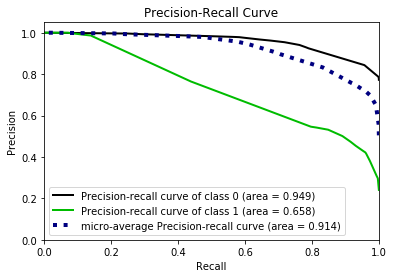

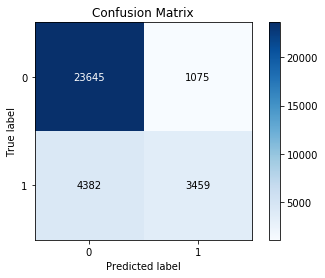

In [11]:
scratch_predictions = my_tree.predict_proba(data[features])
scratch_binary_predictions = my_tree.predict(data[features])

skplt.metrics.plot_precision_recall(data[target].values, scratch_predictions)
score = f1_score(data[target].values, scratch_binary_predictions)
print('f1_score:',round(score, 2))
skplt.metrics.plot_confusion_matrix(data[target].values, scratch_binary_predictions)

## Comparison to sklearn

f1_score: 0.56


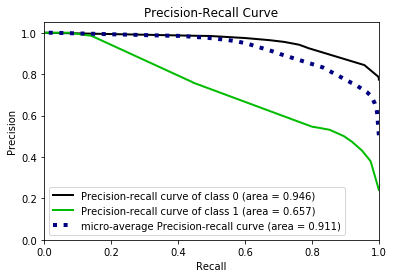

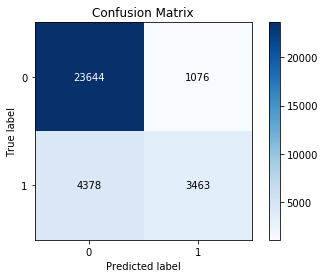

In [12]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth= max_depth)
tree.fit(data[features], data[target])
sklearn_predictions = tree.predict_proba(data[features])
sklearn_binary_predictions = tree.predict(data[features])

skplt.metrics.plot_precision_recall(data[target].values, sklearn_predictions)
score = f1_score(data[target].values, sklearn_binary_predictions)
print('f1_score:',round(score, 2))
skplt.metrics.plot_confusion_matrix(data[target].values, sklearn_binary_predictions)